In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')


from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


from cf_matrix import make_confusion_matrix as cm

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('./Data/df_cleaned.csv', index_col=0)
df = df.reset_index(drop=True)

# Removing Sources of Data Leakage

In [3]:
drop_col = ['yards', 'firstdown', 'batted_pass', 'interception',
            'incompletion_type', 'touchdown']

In [4]:
df = df.drop(drop_col, axis=1)

# Model Training

In [5]:
df['play_action'] = df['play_action'].map(lambda x: 1 if x == True else 0)
df['run_pass_option'] = df['run_pass_option'].map(lambda x: 1 if x == True else 0)
df['blitz_y'] = df['blitz_y'].map(lambda x: 1 if x == True else 0)


In [6]:
df.head()

,name,complete,att_yards,inside_20,goaltogo,blitz_x,hurry,knockdown,pocket_time,direction,quarter,yards_to_goal,down,yards_to_first,hash_mark,play_action,run_pass_option,blitz_y,qb_at_snap,players_rushed,pocket_location,pass_route,seconds_left_in_half,att_dist
0,Aaron Rodgers,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.134,short right,2.0,31,1,10,Right Hash,0,0,0,Shotgun,4.0,Middle,Flat,120,short
1,Aaron Rodgers,1.0,13.0,1.0,0.0,0.0,0.0,0.0,1.820,short right,2.0,14,2,9,Left Hash,0,0,0,Shotgun,4.0,Middle,Go,858,medium
2,Aaron Rodgers,1.0,5.0,0.0,0.0,1.0,0.0,0.0,1.855,short middle,1.0,27,1,10,Left Hash,0,0,1,Shotgun,6.0,Middle,Slant,913,short
3,Aaron Rodgers,1.0,-4.0,0.0,0.0,0.0,0.0,0.0,1.191,short left,1.0,32,2,5,Right Hash,1,1,0,Shotgun,4.0,Middle,WR Screen,953,behind
4,Aaron Rodgers,1.0,-5.0,0.0,0.0,0.0,0.0,0.0,2.697,short right,1.0,56,2,7,Left Hash,0,0,0,Shotgun,4.0,Middle,Flat,1203,behind


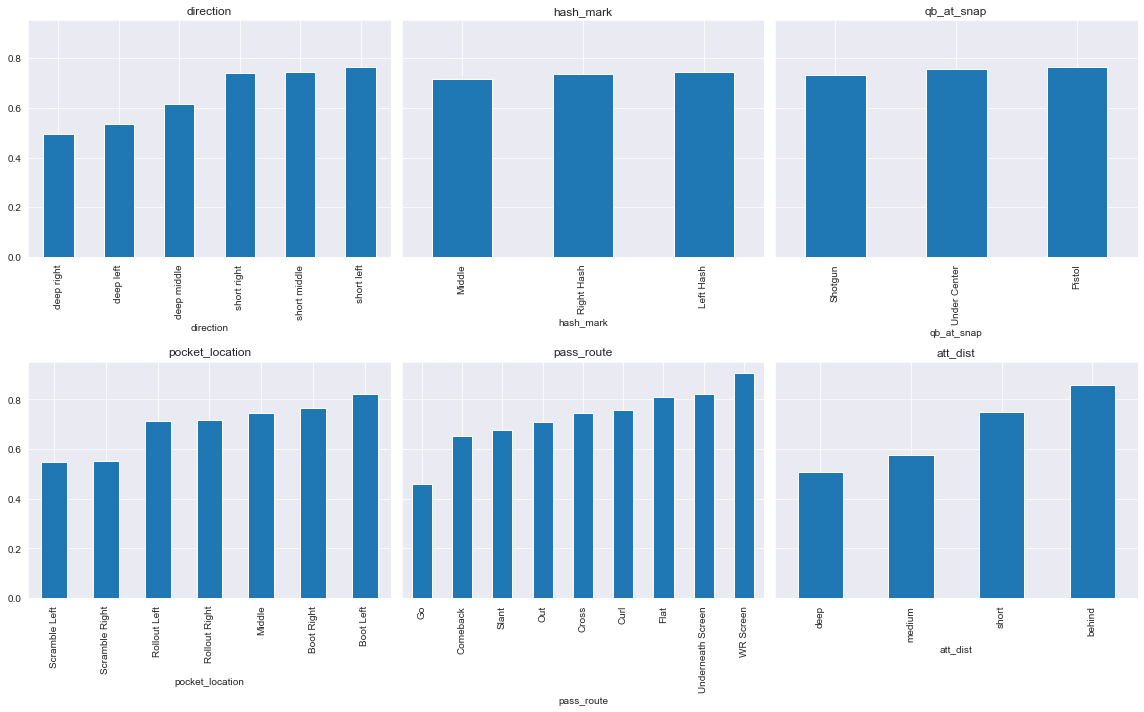

In [7]:
cat = ['direction', 'hash_mark', 'qb_at_snap', 'pocket_location', 'pass_route', 'att_dist']
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(16,10),sharey=True)
for col, ax in zip(cat, axes.flatten()):
    (df.groupby(col)
        .mean()['complete']
        .sort_values()
        .plot
        .bar(ax=ax))
    
    ax.set_title(col)
    
fig.tight_layout()
    


In [8]:
dummies = pd.get_dummies(df[cat], drop_first=True)
dfpre = df.drop(cat, axis=1)
dfpre = pd.concat([dfpre, dummies], axis=1)

In [9]:
scale_cols = ['att_yards', 'pocket_time', 'yards_to_goal', 'yards_to_first', 'players_rushed',
              'seconds_left_in_half', 'quarter', 'down']

array([[<AxesSubplot:title={'center':'att_yards'}>,
        <AxesSubplot:title={'center':'pocket_time'}>,
        <AxesSubplot:title={'center':'yards_to_goal'}>],
       [<AxesSubplot:title={'center':'yards_to_first'}>,
        <AxesSubplot:title={'center':'players_rushed'}>,
        <AxesSubplot:title={'center':'seconds_left_in_half'}>],
       [<AxesSubplot:title={'center':'quarter'}>,
        <AxesSubplot:title={'center':'down'}>, <AxesSubplot:>]],
      dtype=object)

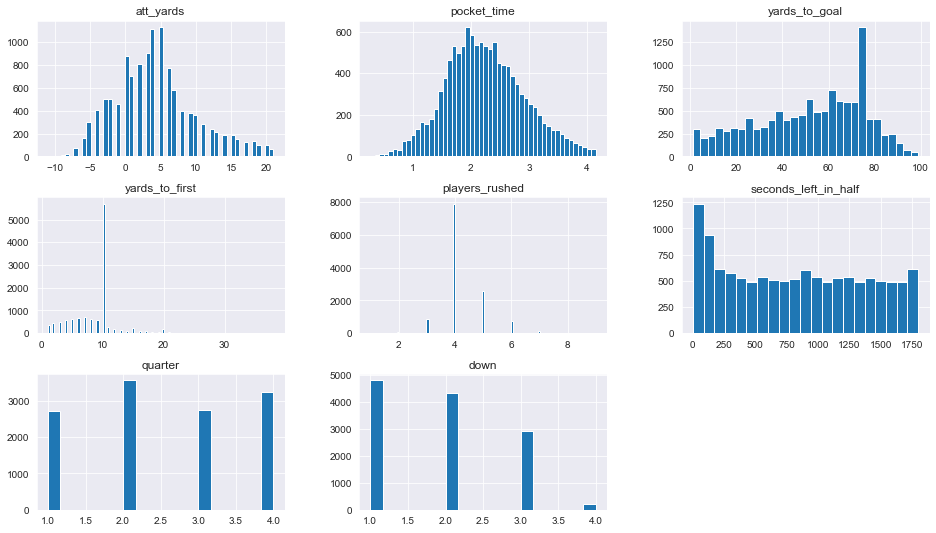

In [10]:
dfpre[scale_cols].hist(figsize=(16,9), bins='auto')

In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
mms = MinMaxScaler()
scaled = mms.fit(dfpre[scale_cols])
scaled_cols = mms.transform(dfpre[scale_cols])
scaled_df = pd.DataFrame(scaled_cols, columns=scale_cols)

In [12]:
dfpre = dfpre.drop(scale_cols, axis=1)
df = pd.concat([dfpre, scaled_df], axis=1)
df

,name,complete,inside_20,goaltogo,blitz_x,hurry,knockdown,play_action,run_pass_option,blitz_y,direction_deep middle,direction_deep right,direction_short left,direction_short middle,direction_short right,hash_mark_Middle,hash_mark_Right Hash,qb_at_snap_Shotgun,qb_at_snap_Under Center,pocket_location_Boot Right,pocket_location_Middle,pocket_location_Rollout Left,pocket_location_Rollout Right,pocket_location_Scramble Left,pocket_location_Scramble Right,pass_route_Cross,pass_route_Curl,pass_route_Flat,pass_route_Go,pass_route_Out,pass_route_Slant,pass_route_Underneath Screen,pass_route_WR Screen,att_dist_deep,att_dist_medium,att_dist_short,att_yards,pocket_time,yards_to_goal,yards_to_first,players_rushed,seconds_left_in_half,quarter,down
0,Aaron Rodgers,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0.34375,0.738279,0.306122,0.243243,0.375,0.066667,0.333333,0.000000
1,Aaron Rodgers,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.75000,0.399794,0.132653,0.216216,0.375,0.476667,0.333333,0.333333
2,Aaron Rodgers,1.0,0.0,0.0,1.0,0.0,0.0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.50000,0.408810,0.265306,0.243243,0.625,0.507222,0.000000,0.000000
3,Aaron Rodgers,1.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.21875,0.237764,0.316327,0.108108,0.375,0.529444,0.000000,0.333333
4,Aaron Rodgers,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.18750,0.625708,0.561224,0.162162,0.375,0.668333,0.000000,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12240,Tyrod Taylor,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0.53125,0.410613,0.775510,0.270270,0.375,0.152222,1.000000,0.333333
12241,Tyrod Taylor,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.53125,0.621844,0.459184,0.216216,0.250,0.505000,0.000000,0.666667
12242,Tyrod Taylor,1.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0.81250,0.650953,0.622449,0.243243,0.375,0.555556,0.000000,0.333333
12243,Tyrod Taylor,1.0,0.0,0.0,1.0,0.0,0.0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0.37500,0.696033,0.755102,0.243243,0.500,0.580000,0.000000,0.000000


In [13]:
df.describe()

,complete,inside_20,goaltogo,blitz_x,hurry,knockdown,play_action,run_pass_option,blitz_y,direction_deep middle,direction_deep right,direction_short left,direction_short middle,direction_short right,hash_mark_Middle,hash_mark_Right Hash,qb_at_snap_Shotgun,qb_at_snap_Under Center,pocket_location_Boot Right,pocket_location_Middle,pocket_location_Rollout Left,pocket_location_Rollout Right,pocket_location_Scramble Left,pocket_location_Scramble Right,pass_route_Cross,pass_route_Curl,pass_route_Flat,pass_route_Go,pass_route_Out,pass_route_Slant,pass_route_Underneath Screen,pass_route_WR Screen,att_dist_deep,att_dist_medium,att_dist_short,att_yards,pocket_time,yards_to_goal,yards_to_first,players_rushed,seconds_left_in_half,quarter,down
count,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000
mean,0.738097,0.122662,0.053001,0.301919,0.068109,0.075868,0.220580,0.067864,0.301919,0.009555,0.026215,0.363740,0.197387,0.383177,0.114659,0.432258,0.813230,0.172887,0.031196,0.884688,0.005962,0.029481,0.009718,0.026133,0.100286,0.159085,0.186117,0.047121,0.189873,0.131891,0.050796,0.069008,0.013965,0.161617,0.625235,0.477976,0.508344,0.519797,0.210259,0.410923,0.454252,0.509950,0.293317
std,0.439688,0.328063,0.224045,0.459109,0.251944,0.264797,0.414655,0.251523,0.459109,0.097285,0.159780,0.481095,0.398043,0.486181,0.318623,0.495410,0.389743,0.378165,0.173855,0.319412,0.076984,0.169159,0.098105,0.159538,0.300393,0.365771,0.389217,0.211907,0.392217,0.338386,0.219590,0.253478,0.117350,0.368114,0.484082,0.183620,0.174497,0.240305,0.106279,0.094364,0.307143,0.368359,0.275197
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.343750,0.386141,0.336735,0.135135,0.375000,0.164444,0.333333,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.468750,0.495363,0.561224,0.243243,0.375000,0.447222,0.333333,0.333333
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.562500,0.620814,0.724490,0.243243,0.500000,0.719444,1.000000,0.666667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0

# Train-Test Split

In [14]:
from sklearn.model_selection import train_test_split as tts

X = df.drop(['name', 'complete'], axis=1)
y = df['complete']
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2,
                                      random_state=123)

In [15]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(9796, 42)
(2449, 42)
(9796,)
(2449,)


## Defining Helper Functions

In [16]:
def build_model(model, X, y, random_state=123, decision_function=True):
    
    X_train, X_test, y_train, y_test = tts(X, y, random_state=random_state,
                                           test_size=0.2)
    model_dict = {}
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    if decision_function == True:
        y_score = model.decision_function(X_test)
    else:
        y_score = model.predict_proba(X_test)[:, 1]
        
    fpr, tpr, thresh = roc_curve(y_test, y_score)
    
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_ = auc(fpr,tpr)
    params = model.get_params()
    cfm = confusion_matrix(y_test, y_pred)
    
    model_dict['model'] = model
    model_dict['y_pred'] = y_pred
    model_dict['y_score'] = y_score
    model_dict['fpr'] = fpr
    model_dict['tpr'] = tpr
    model_dict['thresh'] = thresh
    model_dict['accuracy'] = acc
    model_dict['precision'] = pre
    model_dict['recall'] = rec
    model_dict['f1'] = f1
    model_dict['auc'] = auc_
    model_dict['params'] = params
    model_dict['cfm'] = cfm
    
    print(f'Accuracy: {round(acc, 3)}')
    print(f'Precision: {round(pre, 3)}')
    print(f'Recall: {round(rec, 3)}')
    print(f'F1 Score: {round(f1, 3)}')
    print(f'AUC: {round(auc_, 3)}')
    
    return model_dict

In [17]:
def plot_matrix(cfm):
    
    labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    categories = ['Incomplete', 'Complete']
    matrix = cm(cfm, group_names=labels, 
               categories=categories, cbar=False, cmap='Purples')
    
    return matrix

# Baseline Model

In [18]:
from sklearn.linear_model import LogisticRegression

baseline_log = build_model(LogisticRegression(random_state=123),X,y)

Accuracy: 0.757
Precision: 0.771
Recall: 0.96
F1 Score: 0.855
AUC: 0.69


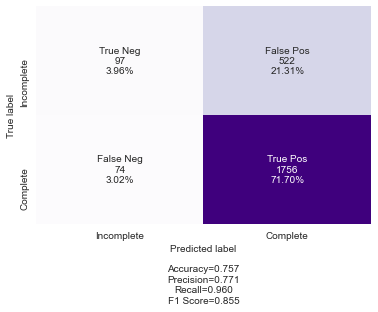

In [19]:
plot_matrix(baseline_log['cfm'])

## Determining Feature Importance

In [20]:
from sklearn.ensemble import RandomForestClassifier


feature_names = X.columns
forest = RandomForestClassifier(random_state=123)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

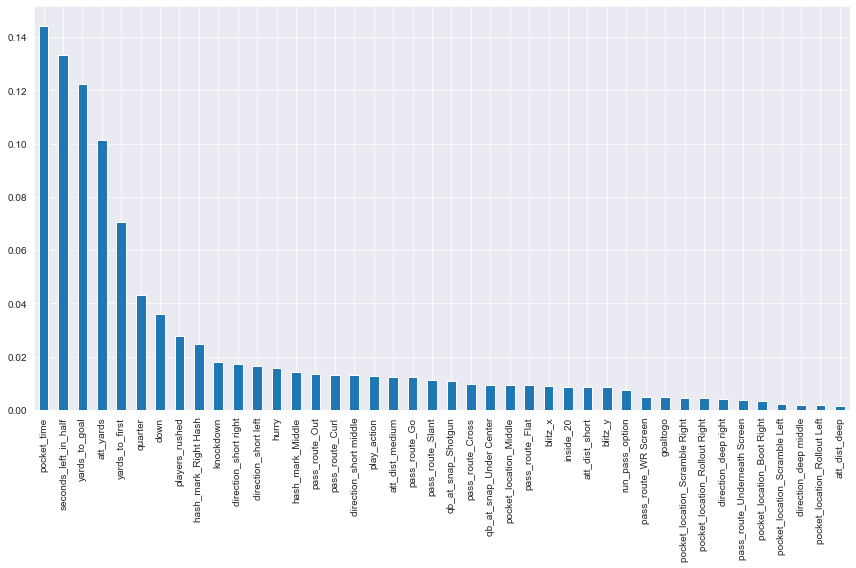

In [21]:
importances = forest.feature_importances_
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12,8))
forest_importances.plot.bar(ax=ax, )

fig.tight_layout()

In [22]:
top5 = forest_importances[:5].keys()
top5

Index(['pocket_time', 'seconds_left_in_half', 'yards_to_goal', 'att_yards',
       'yards_to_first'],
      dtype='object')

## Logistic Regression Top 5 Features

In [23]:
top5_log = build_model(LogisticRegression(random_state=123),X[top5],y )

Accuracy: 0.748
Precision: 0.754
Recall: 0.983
F1 Score: 0.853
AUC: 0.64


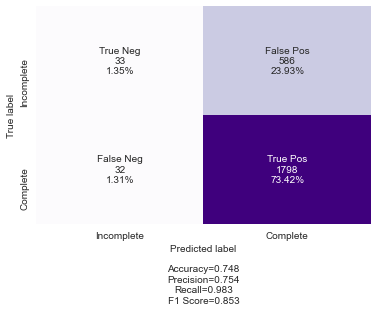

In [24]:
plot_matrix(top5_log['cfm'])

## Random Forest Top 5 Features

In [25]:
top5_rf = build_model(RandomForestClassifier(
                                             n_estimators=500,
                                             criterion='gini',
                                             random_state=123),
                      X[top5],y, decision_function=False)

Accuracy: 0.739
Precision: 0.766
Recall: 0.937
F1 Score: 0.843
AUC: 0.64


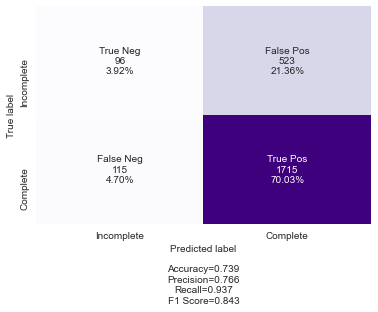

In [26]:
plot_matrix(top5_rf['cfm'])

## KNN Top 5 Features

In [127]:
top5_knn = build_model(KNeighborsClassifier(), X[top5], y, decision_function=False)

Accuracy: 0.72
Precision: 0.772
Recall: 0.886
F1 Score: 0.825
AUC: 0.598


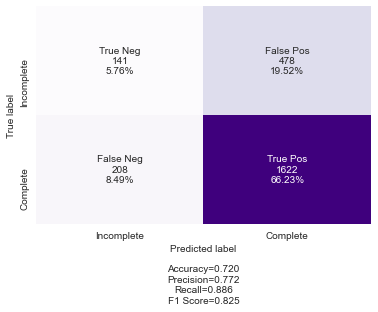

In [128]:
plot_matrix(top5_knn['cfm'])

## Decision Tree Classifier Top 5 Features

In [27]:
from sklearn.tree import DecisionTreeClassifier

top5_tree = build_model(DecisionTreeClassifier(
                                               random_state=123),
                        X[top5], y, decision_function=False)

Accuracy: 0.639
Precision: 0.769
Recall: 0.739
F1 Score: 0.754
AUC: 0.541


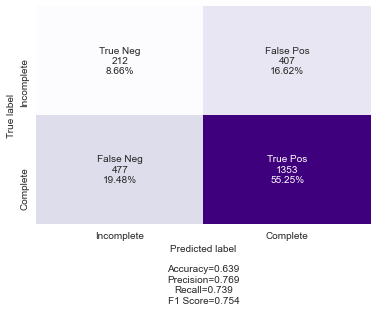

In [28]:
plot_matrix(top5_tree['cfm'])

## Gradient Boosting Classifier Top 5 Features

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

top5_gb = build_model(GradientBoostingClassifier(random_state=123,
                                                 n_estimators=1000),
                      X[top5], y)

Accuracy: 0.732
Precision: 0.763
Recall: 0.931
F1 Score: 0.839
AUC: 0.622


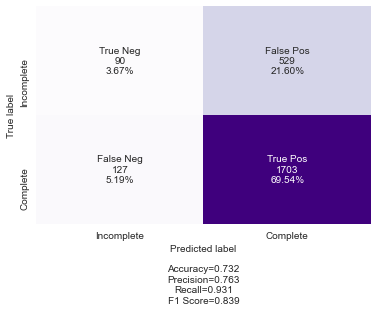

In [30]:
plot_matrix(top5_gb['cfm'])

## AdaBoost Classifier

In [31]:
from sklearn.ensemble import AdaBoostClassifier

top5_ada = build_model(AdaBoostClassifier(random_state=123),
                       X[top5], y)

Accuracy: 0.749
Precision: 0.755
Recall: 0.984
F1 Score: 0.854
AUC: 0.655


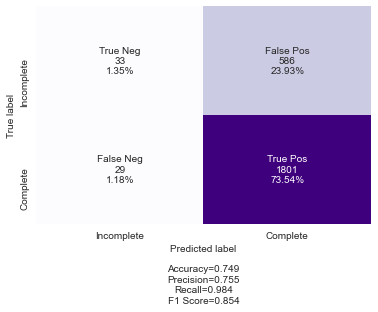

In [32]:
plot_matrix(top5_ada['cfm'])

## XGBoost Classifier Top 5 Features

In [37]:
import xgboost as xgb

top5_xgb = build_model(xgb.XGBClassifier(random_state=123,
                                         n_estimators=500),
                       X[top5], y, decision_function=False)

[18:01:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.703
Precision: 0.767
Recall: 0.864
F1 Score: 0.813
AUC: 0.597


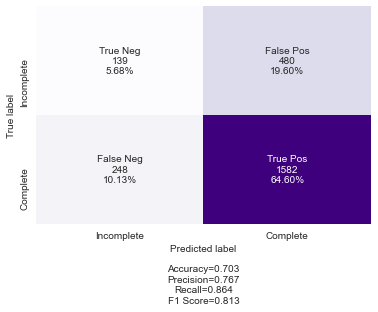

In [38]:
plot_matrix(top5_xgb['cfm'])

# GridSearchCV on Log and Ada Classifiers

In [47]:
X_train, X_test, y_train, y_test = tts(X[top5], y, test_size=0.2, random_state=123)

In [84]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

log_pipe = Pipeline([('log', LogisticRegression(random_state=123))])

param_grid = [
    {'log__penalty' : ['l1', 'l2'],
     'log__solver' : ['liblinear', 'lbfgs'],
     'log__C' : [0.001, 0.01, 0.1, 1],
     'log__tol' : [0.0001, 0.001, 0.01, 0.1, 1],
     'log__max_iter' : list(range(50, 101, 10))}
]


gs_log = GridSearchCV(log_pipe, 
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=5, verbose=False, n_jobs=-1)

gs_log.fit(X_train, y_train)
gs_log.best_params_
# best_model = buid_model(clf, X[top5])

/Users/scott/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.73581054 0.73581054 0.73581054 0.73581054 0.73581054        nan
        nan        nan        nan        nan 0.73581054 0.73581054
 0.73581054 0.73581054 0.73581054 0.73581054 0.73581054 0.73581054
 0.73581054 0.73581054 0.73581054 0.73581054 0.73581054 0.73581054
 0.73581054        nan        nan        nan        nan        nan
 0.73581054 0.73581054 0.73581054 0.73581054 0.73581054 0.73581054
 0.73581054 0.73581054 0.73581054 0.73581054 0.73581054 0.73581054
 0.73581054 0.73581054 0.73581054        nan        nan        nan
        nan        nan 0.73581054 0.73581054 0.73581054 0.73581054
 0.73581054 0.73581054 0.73581054 0.73581054 0.73581054 0.73581054
 0.73581054 0.73581054 0.73581054 0.73581054 0.73581054        nan
        nan        nan        nan        nan 0.73581054 0.73581054
 0.73581054 0.73581054 0.735810

{'log__C': 0.1,
 'log__max_iter': 50,
 'log__penalty': 'l1',
 'log__solver': 'liblinear',
 'log__tol': 0.1}

In [81]:
gs_log.score(X_train, y_train)

0.736014699877501

In [82]:
test = build_model(gs_log.best_estimator_, X[top5], y, decision_function=False)
test['accuracy']

Accuracy: 0.748
Precision: 0.748
Recall: 0.999
F1 Score: 0.856
AUC: 0.623


0.7480604328297265

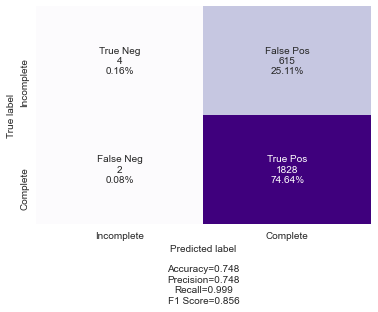

In [83]:
plot_matrix(test['cfm'])

Gridsearch models are returning near perfect recall scores. The models are heavily favoring the positive cases.

# Dealing With Class Imbalance Using SMOTE

In [98]:
from imblearn.over_sampling import SMOTE

In [129]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X[top5],y)

In [133]:
y.value_counts(normalize=True)

1.0    0.738097
0.0    0.261903
Name: complete, dtype: float64

In [134]:
y_smote.value_counts(normalize=True)

0.0    0.5
1.0    0.5
Name: complete, dtype: float64

Accuracy: 0.809
Precision: 0.796
Recall: 0.83
F1 Score: 0.813
AUC: 0.886


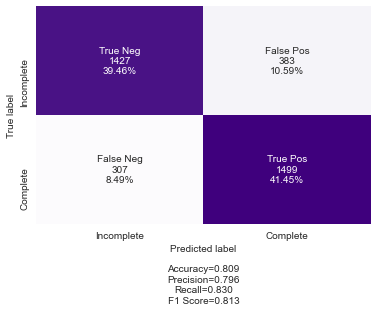

In [132]:
rf_smote = build_model(RandomForestClassifier(),
                X_smote, y_smote, decision_function=False)
plot_matrix(rf_smote['cfm'])

Accuracy: 0.595
Precision: 0.591
Recall: 0.611
F1 Score: 0.601
AUC: 0.636


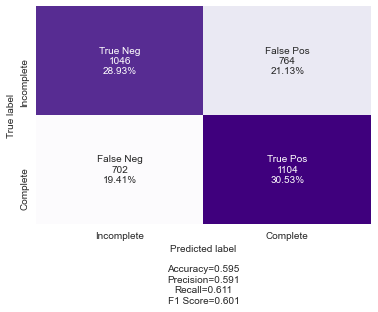

In [136]:
log_smote = build_model(LogisticRegression(random_state=123),
                        X_smote, y_smote)
plot_matrix(log_smote['cfm'])

In [146]:
rf_smote['params']

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [152]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = list(range(100,1001,100))
max_features = ['auto', 'sqrt']
max_depth = list(range(10,111,10))
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
bootstrap = ['True', 'False']

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               n_iter = 100,
                               cv = 3,
                               verbose = 1,
                               n_jobs = -1,
                               scoring = 'accuracy')
rf_random.fit(X_trainSM, y_trainSM)
# pred = rf_random.predict(X_testSM)
# rf_random.score(y_testSM, pred)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 1. ... 1. 1. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [169]:
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': 'False'}

In [164]:
rf_smoteCV = build_model(rf_random.best_estimator_, X_smote, y_smote, decision_function=False)
rf_smoteCV

Accuracy: 0.815
Precision: 0.797
Recall: 0.844
F1 Score: 0.82
AUC: 0.889


{'model': RandomForestClassifier(bootstrap='False', max_depth=30, max_features='sqrt',
                        n_estimators=500),
 'y_pred': array([1., 0., 1., ..., 0., 1., 0.]),
 'y_score': array([0.6745458 , 0.328     , 0.76962791, ..., 0.428     , 0.55859561,
        0.128     ]),
 'fpr': array([0.        , 0.        , 0.        , ..., 0.99392265, 0.99889503,
        1.        ]),
 'tpr': array([0.00000000e+00, 5.53709856e-04, 1.10741971e-03, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 'thresh': array([1.99800000e+00, 9.98000000e-01, 9.94000000e-01, ...,
        6.00000000e-03, 1.42857143e-04, 0.00000000e+00]),
 'accuracy': 0.8149889380530974,
 'precision': 0.7971772085729221,
 'recall': 0.844407530454042,
 'f1': 0.8201129335842969,
 'auc': 0.8894538157033338,
 'params': {'bootstrap': 'False',
  'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 30,
  'max_features': 'sqrt',
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impu

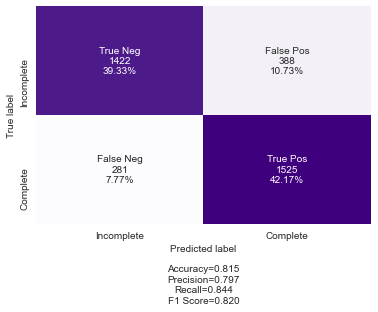

In [165]:
plot_matrix(rf_smoteCV['cfm'])

In [179]:
rf_smoteCV['params']

{'bootstrap': 'False',
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 30,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [173]:
model = rf_smoteCV['model']
model.fit(X_trainSM, y_trainSM)
pred = model.predict(X_testSM)
print(classification_report(y_testSM, pred))

              precision    recall  f1-score   support

         0.0       0.83      0.79      0.81      1810
         1.0       0.80      0.84      0.82      1806

    accuracy                           0.81      3616
   macro avg       0.81      0.81      0.81      3616
weighted avg       0.81      0.81      0.81      3616



In [176]:
model.predict_proba(X_testSM).shape

(3616, 2)

In [181]:
model.predict(X_testSM).shape

(3616,)